In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Assign data into variables as DataFrames using Pandas
ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
people = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
title = pd.read_csv('zippedData/imdb.name.basics.csv.gz', index_col='nconst')
money = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Question 1: Does the gender of the main character affect movie rating?

In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9611 entries, tt7131622 to tt9165634
Data columns (total 2 columns):
averagerating    9611 non-null float64
numvotes         9611 non-null int64
dtypes: float64(1), int64(1)
memory usage: 545.3+ KB


In [22]:
# Movies with more than 1000 ratings, sorted by highest rating.
ratings = ratings.sort_values(by=['averagerating'], ascending=False).loc[ratings['numvotes'] > 1000]
print(ratings)

           averagerating  numvotes
tconst                            
tt7131622            9.7      5600
tt6058226            9.6      2604
tt4131686            9.6      1339
tt5963218            9.5      6509
tt7738784            9.4      9629
...                  ...       ...
tt9364684            1.4      3511
tt4404474            1.3      6249
tt8081062            1.3      3244
tt7221896            1.3     36986
tt9165634            1.2      3445

[9611 rows x 2 columns]


In [8]:
# Contains information about the main people involved with the movie in the order of importance.
people.head(10)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,NaN,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,NaN,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,NaN,"[""Lady Delia Morrison""]"
8,tt0323808,5,nm0362736,director,NaN,NaN
9,tt0323808,6,nm0811056,producer,producer,NaN


In [23]:
# Indexed the main person in each movie and dropped unnecessary columns.
main_person = people.loc[people['ordering'] == 1].set_index('nconst').drop(columns=['job', 'ordering']) \
.dropna(subset=['category'])

In [29]:
# Now we can attempt to answer the first question - does the gender of the main character affect movie rating?

# Join relevant dataframes by the identifier codes and dropped unnecessary columns.
first_q = main_person.join(title, how='left').set_index('tconst').join(ratings, how='right') \
.drop(columns=['primary_profession', 'known_for_titles', 'death_year', 'birth_year'])

# On a few occations, the main person (with order number 1) is neither an actor or an actress.
# Use indexing to avoid those few datasets.
first_q = first_q.loc[(first_q['category'] == 'actor') | (first_q['category'] == 'actress')]

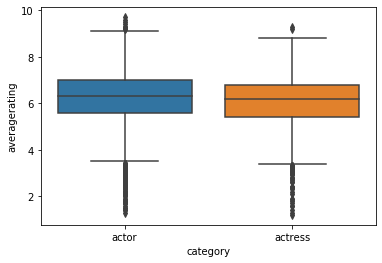

In [30]:
# Graph a boxplot to visualize this data
sns.boxplot(x=first_q.category, y=first_q.averagerating)

/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


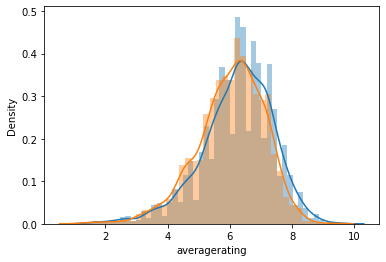

In [33]:
# Boxblot doesn't show much difference - how about their distributions?
first_q_actor = first_q.loc[first_q['category'] == 'actor']
first_q_actress = first_q.loc[first_q['category'] == 'actress']
sns.distplot(first_q_actor.averagerating)
sns.distplot(first_q_actress.averagerating)

/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Rating Distribution by Gender of Main Character')

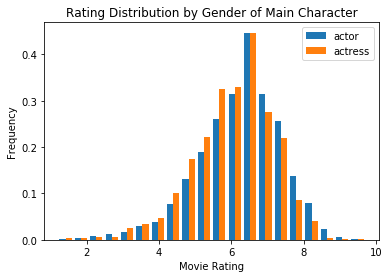

In [34]:
# Another look at their distributions:
plt.hist([first_q_actor.averagerating, first_q_actress.averagerating], bins=20, density=True, label=['actor', 'actress'])
plt.legend()
plt.xlabel('Movie Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution by Gender of Main Character')

In [35]:
# How about the number of actors and actresses?
first_q.category.value_counts(normalize=True)

actor      0.691767
actress    0.308233
Name: category, dtype: float64

## Question 1 - Findings:
- The gender of the main character does not affect movie rating.
- However, male were more than twice as likely to be the main actor than female actresses.

## Question 2: How have the movie industry's production costs and revenue changed over the years?

In [17]:
# Change the data type of the monetary values from string to integers.
# Divide by a million so that numbers are easier to read.
money.production_budget = money.production_budget.map(lambda x: int(x[1:].replace(',', '')) / 1000000)
money.domestic_gross = money.domestic_gross.map(lambda x: int(x[1:].replace(',', ''))/ 1000000)
money.worldwide_gross = money.worldwide_gross.map(lambda x: int(x[1:].replace(',', ''))/ 1000000)

# Keep track of data by the release year.
money.release_date = money.release_date.map(lambda x: int(x[-4:]))

# Index data from the year 1998 or earlier.
money = money.loc[money['release_date'] >= 1998]

# Index data that is in the 75th quartile in terms of production budget.
money = money.loc[money['production_budget'] > money.production_budget.quantile(.75)]

# Drop data from the year 2019 and 2020, due to incomplete data.
money = money.groupby(['release_date']).mean().drop([2020, 2019]).drop(['id'], axis=1)

''

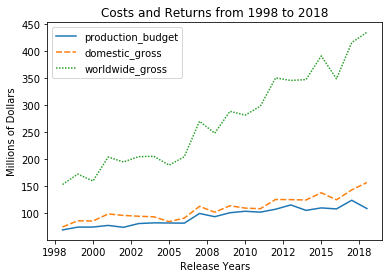

In [20]:
# Visualize the data as a line plot:
g = sns.lineplot(data=money)
g.set_title('Costs and Returns from 1998 to 2018')
sns.set
xlabels = ['{0:.0f}'.format(x) for x in g.get_xticks()]
g.set_ylabel('Millions of Dollars')
g.set_xlabel('Release Years')
g.set_xticklabels(xlabels)
;

## Question 2 - Findings:
- The production costs, domestic revenue, and international revenue have been growing steadily.
- International revenue has shown impressive growth, almost tripling from the year 1998 to 2018.
- Therefore, movies that are produced should aim not only for domestic audiences, but for international audiences.
- This would affect many aspects of the movie such as genre choice, production language, and many more.
- Further investigation on how to thrive in the internation market would be necessary.
- Moreover, further data gathering and analysis should be done to investigate how COVID-19 disrupted this trend.